# Linear regression on HadCRUT v5

- [Section 1](#1)
- [Section 2](#2)
- [Section 3](#3)



In [113]:
# Questions for Nathan
# Compond uncertainty in estimating several means simultaneously
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from cartopy import crs as ccrs, feature as cfeature
from sklearn.linear_model import LinearRegression
from formulaic import Formula
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table



# Plotting config 
plt.rcParams['figure.figsize'] = [12, 8]
%config InlineBackend.figure_format = "retina"

In [5]:
dataset = xr.open_dataset("data/HadCRUT.5.0.2.0.analysis.anomalies.1.nc")

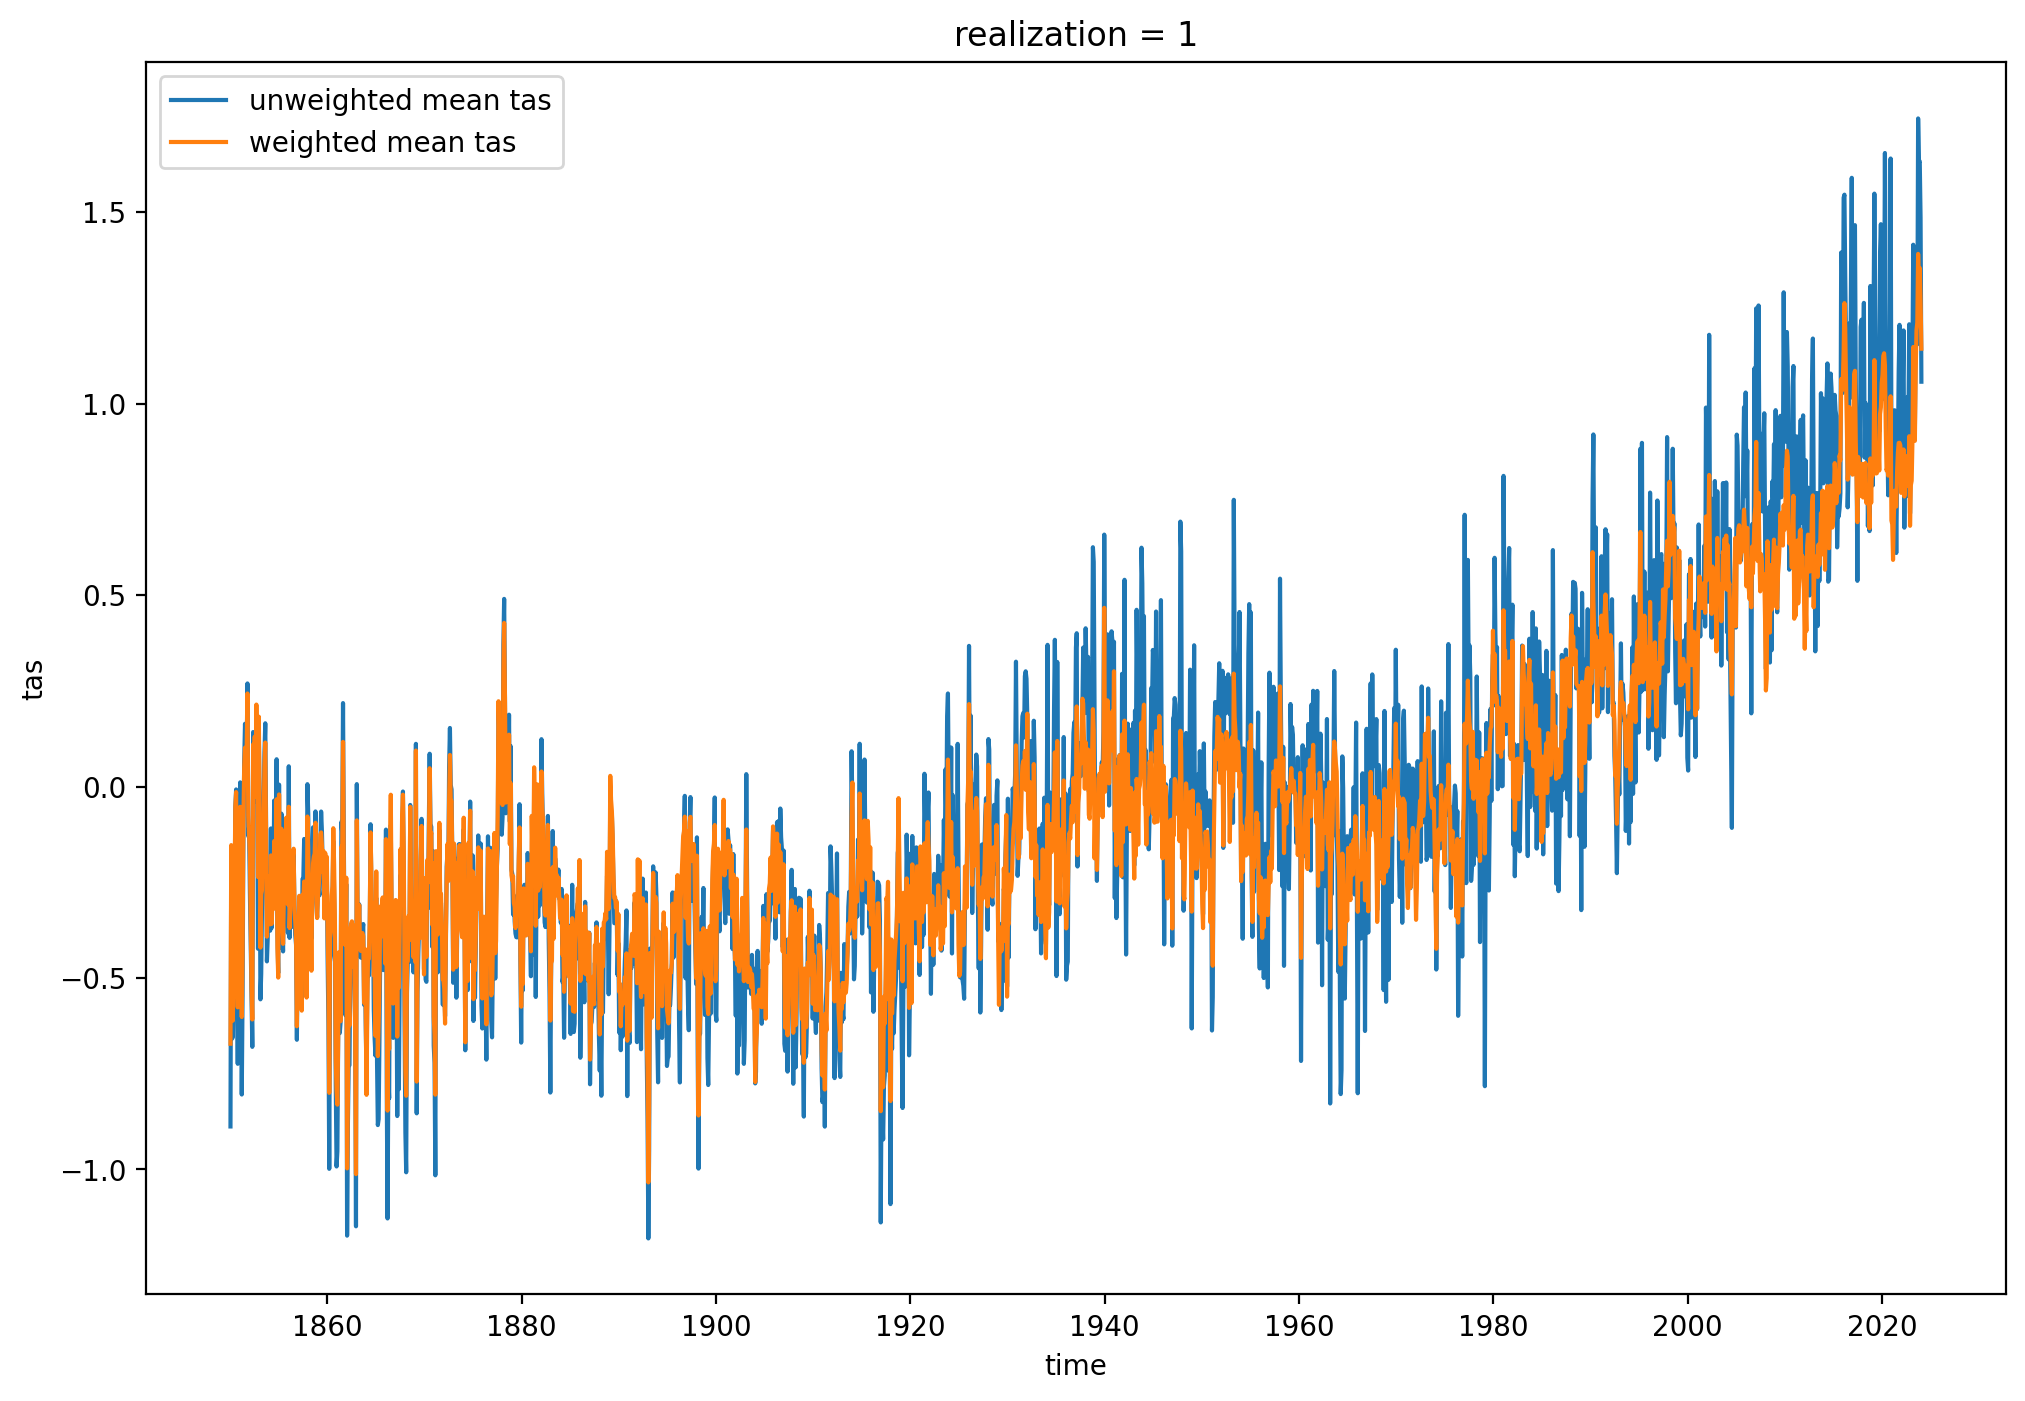

In [6]:
# Explain need for weighted average 

weights = np.cos(np.deg2rad(dataset.tas.latitude))
weights.name = "weights"
dataset_weighted = dataset.tas.weighted(weights)
dataset.tas.mean(dim=("longitude", "latitude")).plot(label="unweighted mean tas")
dataset_weighted.mean(dim=("longitude", "latitude")).plot(label="weighted mean tas")

plt.legend()

# Feature Preparation

If we use a pandas dataframe, statsmodel will use the column labels to annotate the results

In [7]:
global_anoms = dataset_weighted.mean(dim=("longitude", "latitude"))

anoms_df = global_anoms.to_pandas().reset_index()
anoms_df = anoms_df.rename({0: "anomaly"}, axis=1)
anoms_df["time_int"] = anoms_df["time"].astype("int")

# Simple linear regression using StatsModels

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                anomaly   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.519
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 03 Apr 2024   Prob (F-statistic):                nan
Time:                        13:51:39   Log-Likelihood:                -276.23
No. Observations:                2089   AIC:                             554.5
Df Residuals:                    2088   BIC:                             560.1
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -4.455e-38   9.22e-40    -48.340      0.000   -4.64e-38   -4.27e-38
time_int    1.541e-19   3.19e-21     48.340      0.000    1.48e-19     1.6e-19
==============================================================================
Omnibus:                      110.252   Durbin-Watson:                   0.267
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              128.491
Skew:                           0.566   Prob(JB):                     1.25e-28
Kurtosis:                       3.440   Cond. No.                     2.27e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.27e+18. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

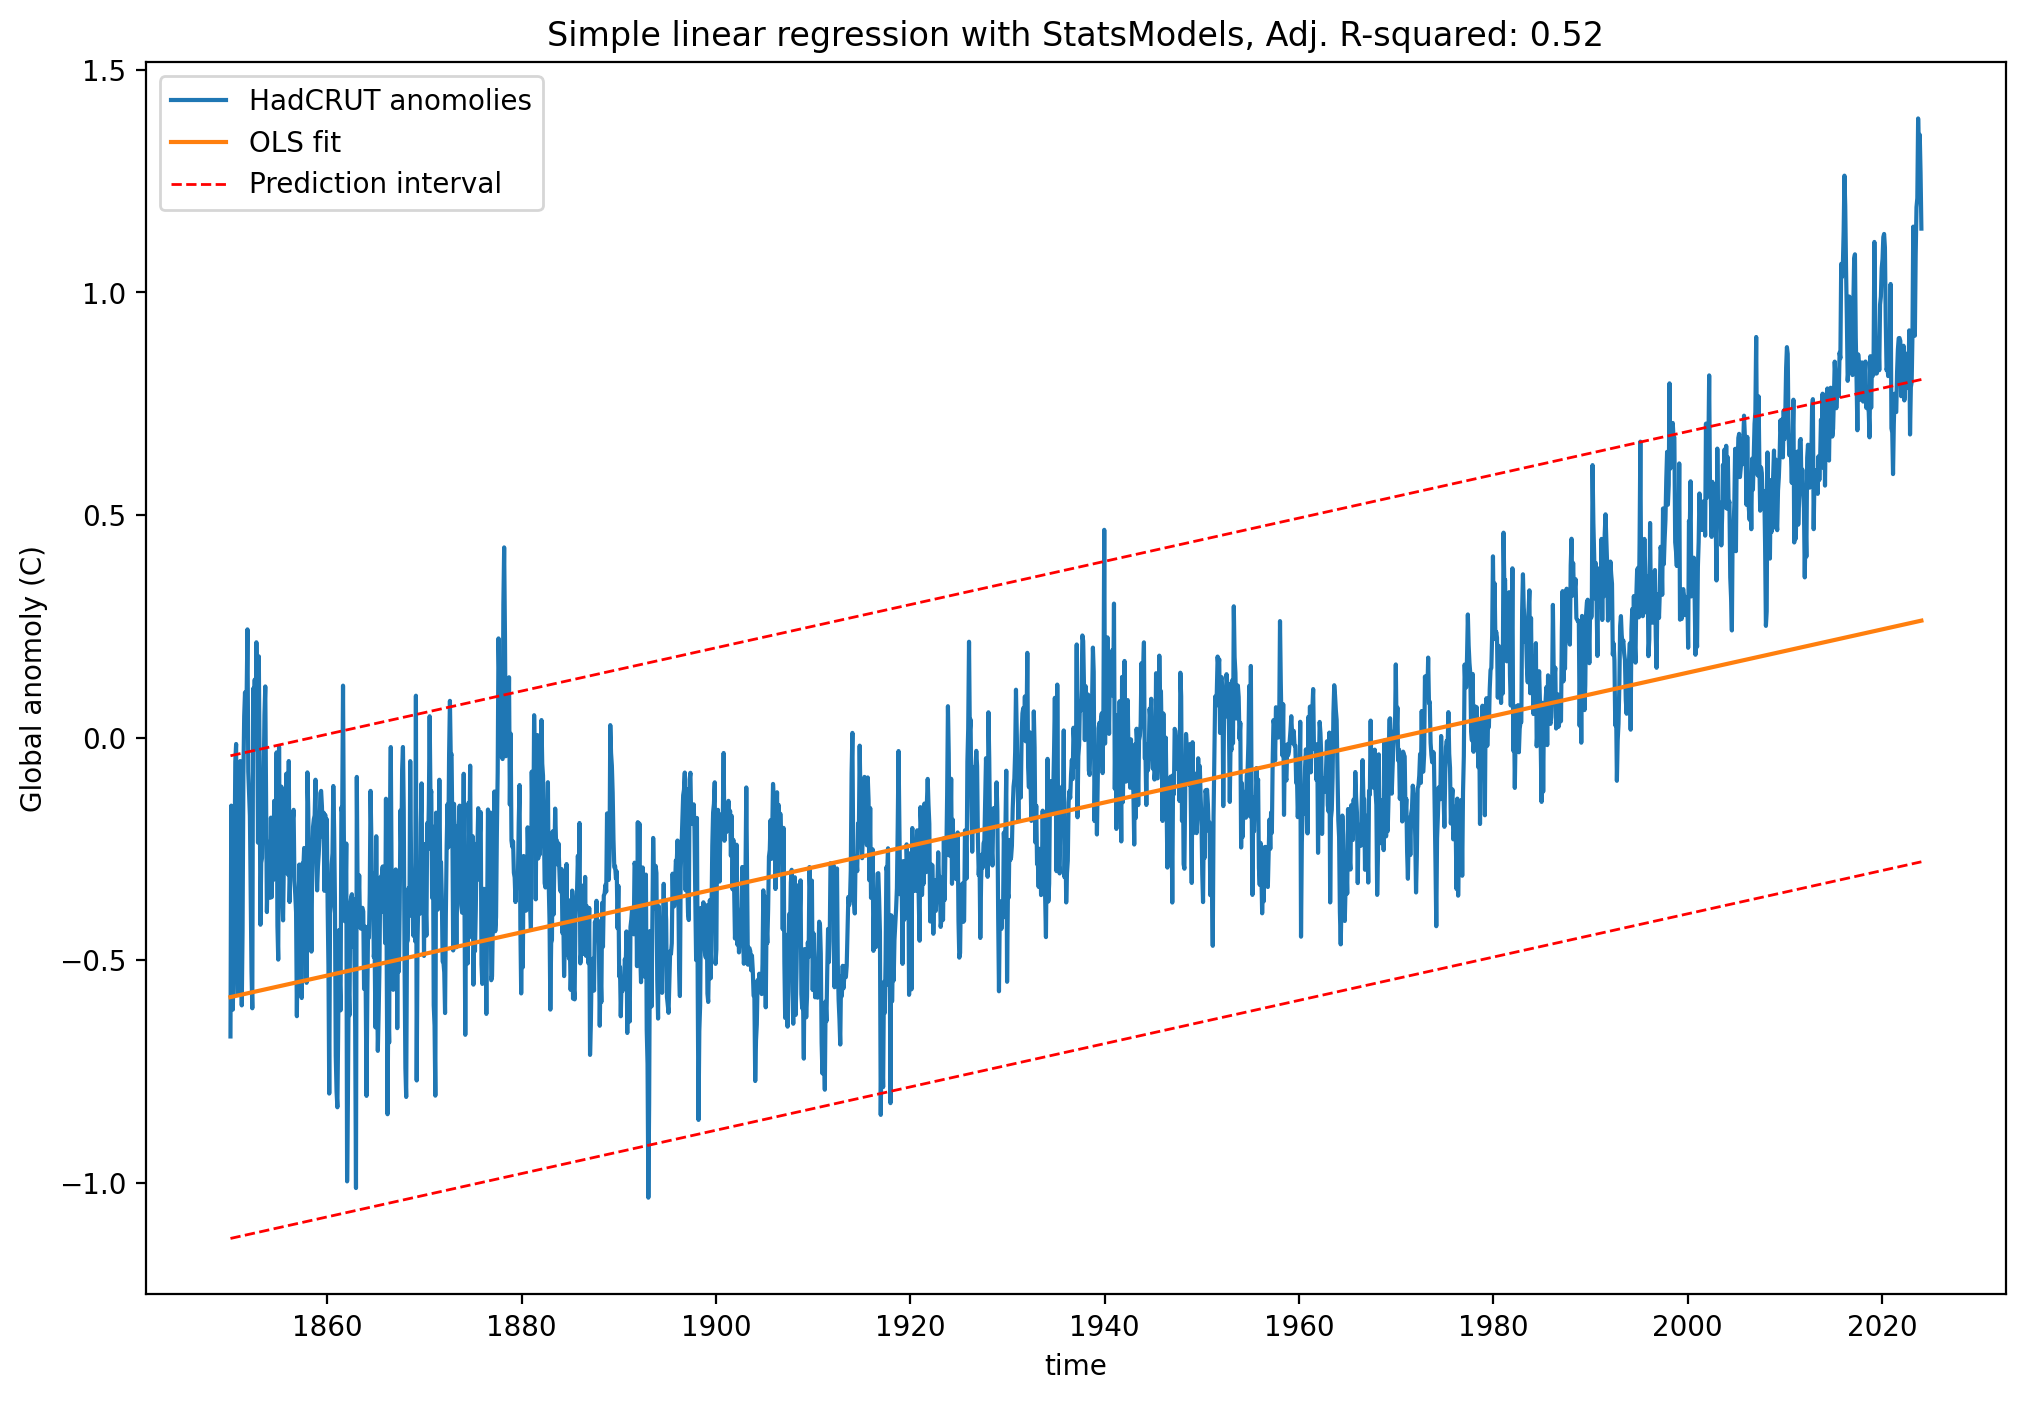

In [124]:
# Model
y, X = Formula('anomaly ~ time_int').get_model_matrix(anoms_df)

model = sm.OLS(y, X)
results = model.fit()

# Results

# Table
display(results.summary())

# Plot
global_anoms.plot(label="HadCRUT anomolies")
plt.plot(anoms_df["time"].values, results.predict(X), label="OLS fit")

def add_prediction_bands(x, results):
    st, data, ss2 = summary_table(results, alpha=0.05)
    
    fittedvalues = data[:, 2]
    predict_mean_se  = data[:, 3]
    predict_mean_ci_low, predict_mean_ci_upp = data[:, 4:6].T
    predict_ci_low, predict_ci_upp = data[:, 6:8].T
    
    plt.plot(x, predict_ci_low, 'r--', lw=1, label="Prediction interval")
    plt.plot(x, predict_ci_upp, 'r--', lw=1)

add_prediction_bands(anoms_df["time"].values, results)

plt.ylabel("Global anomoly (C)")
plt.title(f"Simple linear regression with StatsModels, Adj. R-squared: {results.rsquared_adj:.2}")
plt.legend()


## Our model doesn't fit the data very well 
1. The response mean isn't a linear function of time

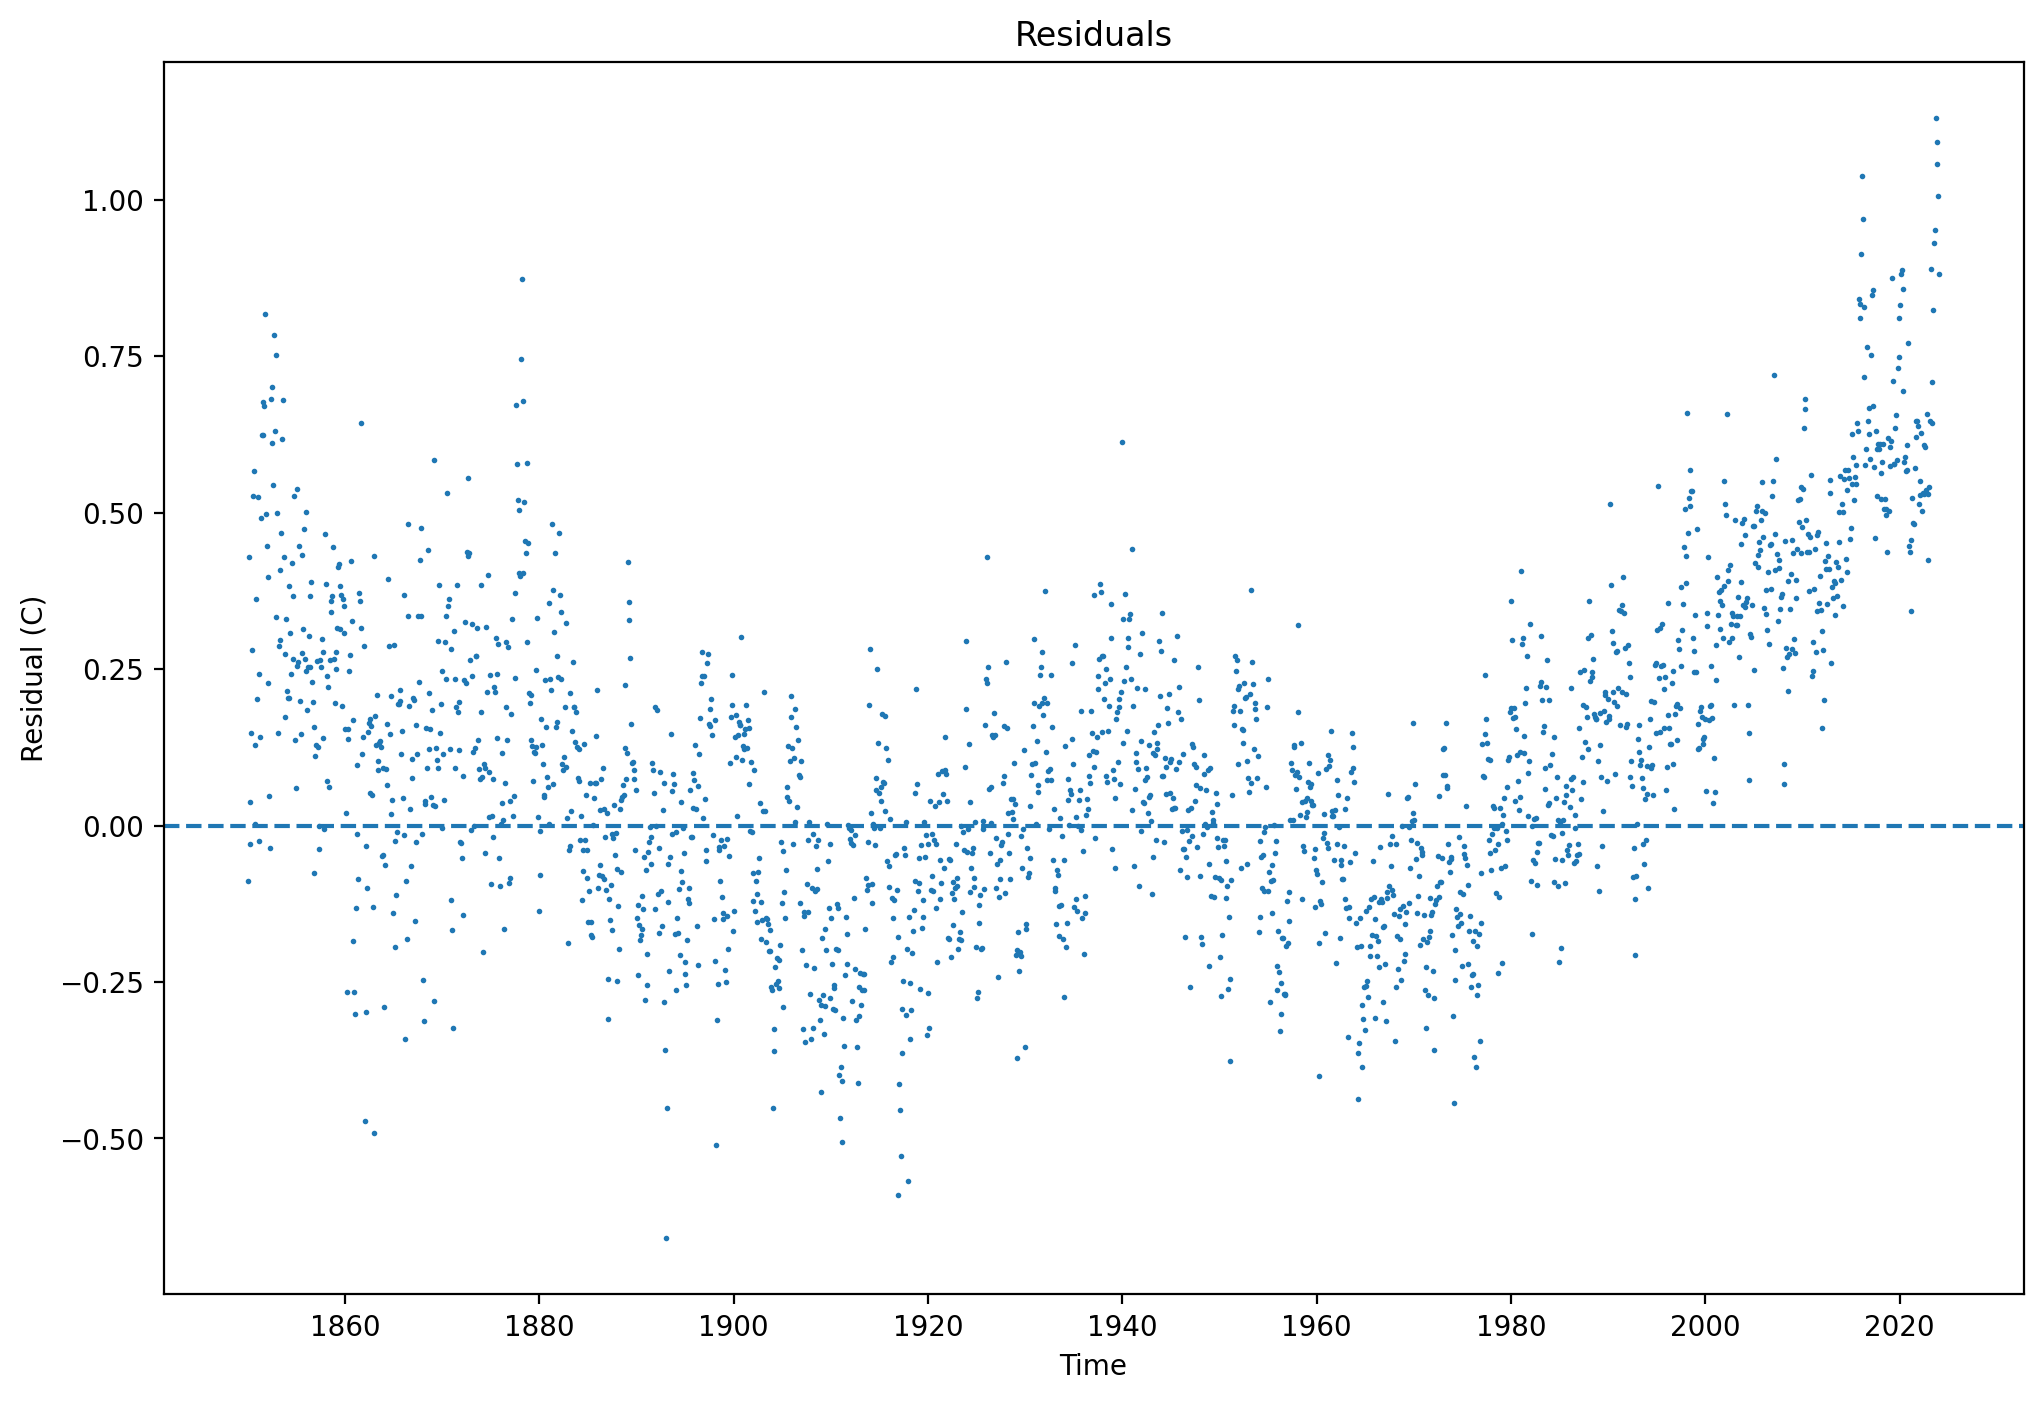

In [97]:
plt.scatter(anoms_df["time"], results.resid, s=1)
plt.title("Residuals")
plt.xlabel("Time")
plt.ylabel("Residual (C)")
plt.axhline(0, linestyle="--")

# Simple linear regression using sklearn

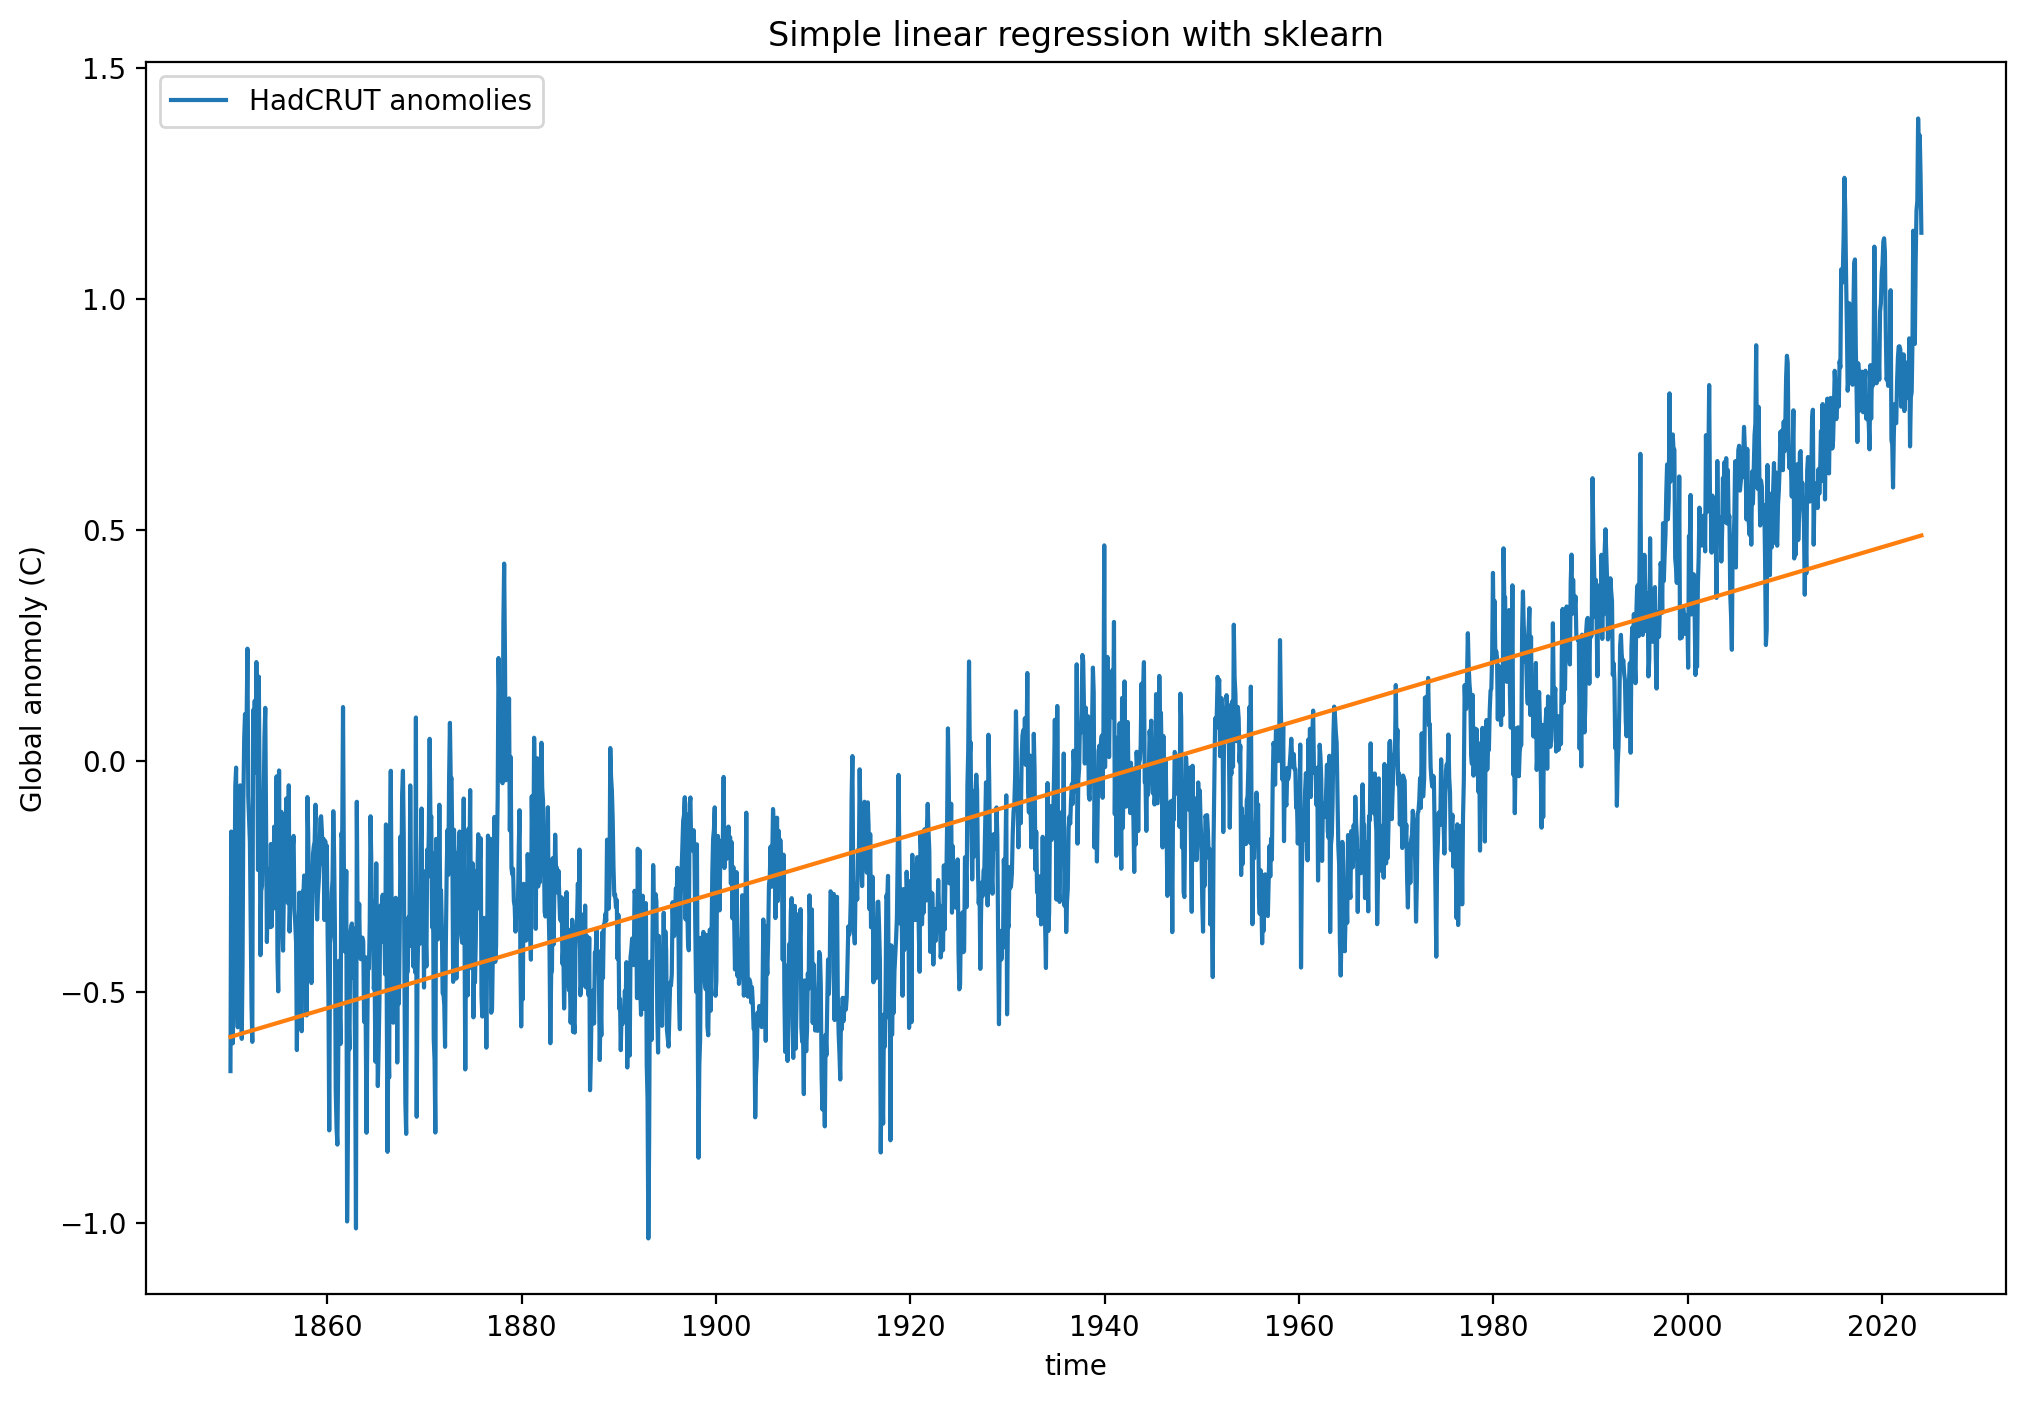

In [99]:
y_sk = global_anoms.values
X_sk = global_anoms.time.values.astype("int").reshape(-1, 1)

reg = LinearRegression()
reg.fit(X_sk, y_sk)


global_anoms.plot(label="HadCRUT anomolies")
plt.plot(global_anoms.time.values, reg.predict(X_sk))
plt.ylabel("Global anomoly (C)")
plt.title("Simple linear regression with sklearn")
plt.legend()

# I'm not sure why sklearn and statsmodels gave different intercept values

In [112]:
print(f"SM time parameter:      {results.params["time_int"]:.4} ")
print(f"sklearn time parameter: {reg.coef_[0]:.4} ")

SM time parameter:      1.541e-19 
sklearn time parameter: 1.977e-19 


# Polynomial regression, StatsModel

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                anomaly   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.519
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 03 Apr 2024   Prob (F-statistic):                nan
Time:                        13:53:08   Log-Likelihood:                -276.23
No. Observations:                2089   AIC:                             554.5
Df Residuals:                    2088   BIC:                             560.1
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -4.455e-38   9.22e-40    -48.340      0.000   -4.64e-38   -4.27e-38
time_int    1.541e-19   3.19e-21     48.340      0.000    1.48e-19     1.6e-19
==============================================================================
Omnibus:                      110.252   Durbin-Watson:                   0.267
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              128.491
Skew:                           0.566   Prob(JB):                     1.25e-28
Kurtosis:                       3.440   Cond. No.                     2.27e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.27e+18. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

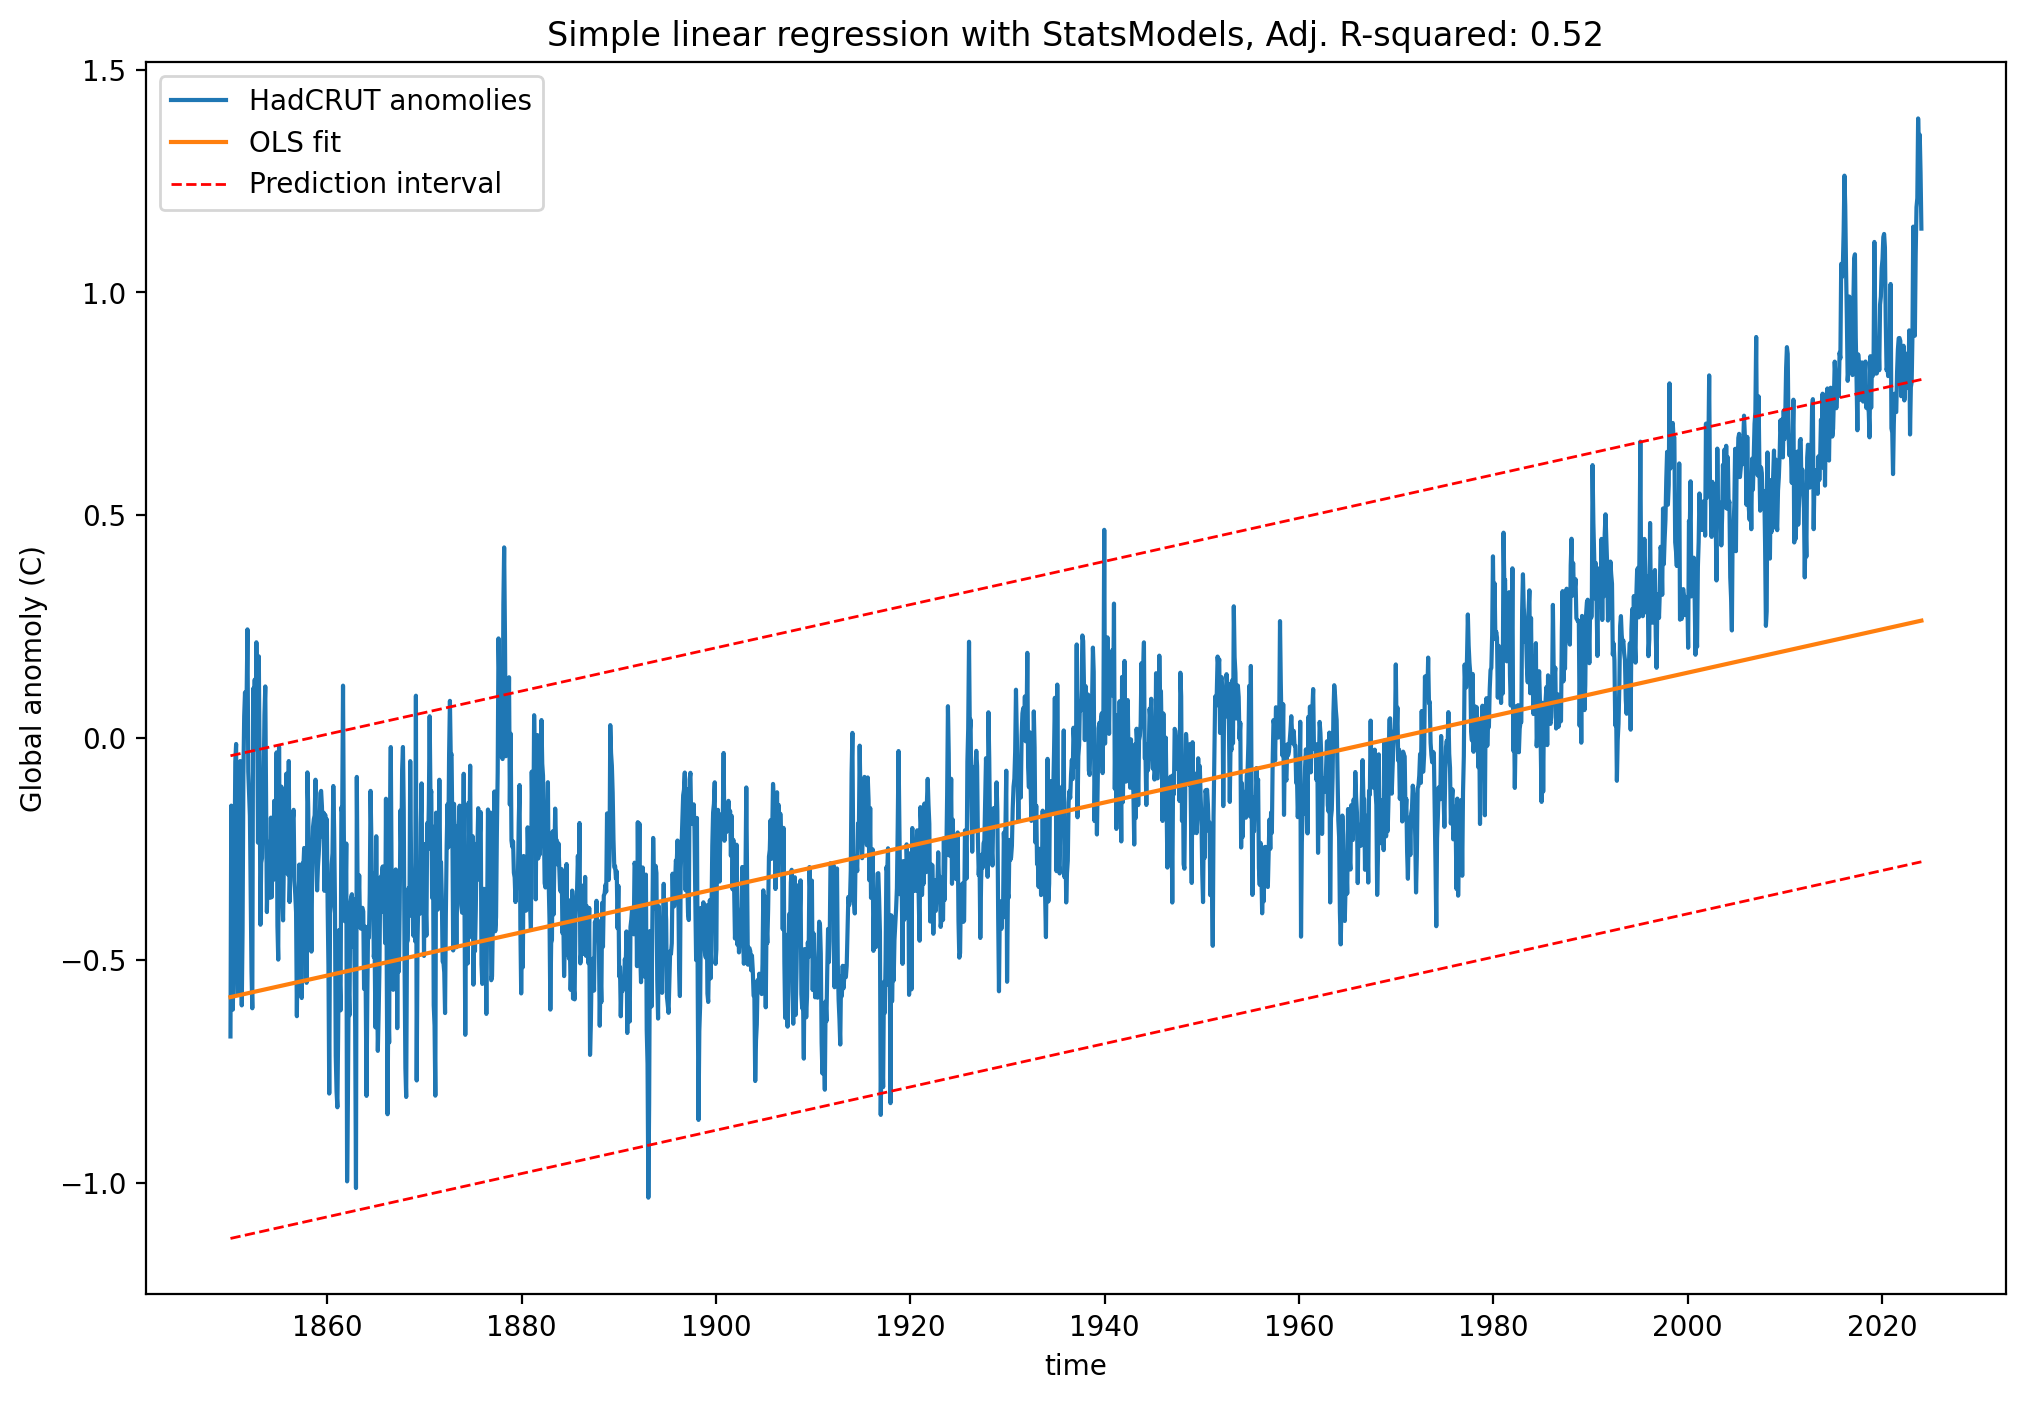

In [129]:
# Model
y, X = Formula('anomaly ~ time_int**2').get_model_matrix(anoms_df)

model = sm.OLS(y, X)
results = model.fit()

# Results

# Table
display(results.summary())

# Plot
global_anoms.plot(label="HadCRUT anomolies")
plt.plot(anoms_df["time"].values, results.predict(X), label="OLS fit")

def add_prediction_bands(x, results):
    st, data, ss2 = summary_table(results, alpha=0.05)
    
    fittedvalues = data[:, 2]
    predict_mean_se  = data[:, 3]
    predict_mean_ci_low, predict_mean_ci_upp = data[:, 4:6].T
    predict_ci_low, predict_ci_upp = data[:, 6:8].T
    
    plt.plot(x, predict_ci_low, 'r--', lw=1, label="Prediction interval")
    plt.plot(x, predict_ci_upp, 'r--', lw=1)

add_prediction_bands(anoms_df["time"].values, results)

plt.ylabel("Global anomoly (C)")
plt.title(f"Simple linear regression with StatsModels, Adj. R-squared: {results.rsquared_adj:.2}")
plt.legend()


In [ ]:
add_prediction_bands(anoms_df["time"].values, results)
